In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from IPython.core.display import display
import plotly.express as px

In [2]:
train = pd.read_csv('../data/train.csv', sep='|')

In [3]:
train_target = train['fraud']
train_feature = train.drop('fraud', axis=1)
methods = {'RF': (RandomForestClassifier(random_state=0), None),
           'KNN': (KNeighborsClassifier(), None),
           'SVC': (SVC(random_state=0), None),
           'MLP': (MLPClassifier((10, 10, 10), max_iter=500, random_state=0), None),
           'XGBoost': (XGBClassifier(use_label_encoder=False, random_state=0), {'eval_metric': 'logloss'}),
           'CatBoost': (CatBoostClassifier(random_state=0), {'verbose': False})
          }

In [4]:
def retailer_profit(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    cost = sum((y_true & y_pred) * 5    # Detected fraud
           + (y_true & ~y_pred) * -5    # Undetected fraud
           + (~y_true & y_pred) * -25)  # Wrong detect as fraud
    return cost

In [5]:
cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
method_results = []
for name, method in methods.items():
    cv_results = cross_validate(method[0],
                                train_feature,
                                train_target,
                                cv=cross_val,
                                scoring={'f1': 'f1', 'profit': make_scorer(retailer_profit)},
                                fit_params=method[1]
                               )
    method_results.append(pd.DataFrame(cv_results).mean().rename(name))
method_results = pd.DataFrame(method_results)
method_results

,fit_time,score_time,test_f1,test_profit
RF,0.149214,0.008434,0.707148,-6.5
KNN,0.002463,0.005471,0.000000,-59.5
SVC,0.015617,0.003357,0.000000,-52.0
MLP,0.413566,0.001730,0.191894,-90.5
XGBoost,0.043883,0.002454,0.807231,-4.5
CatBoost,1.195701,0.010233,0.800844,-1.5


In [6]:
ros = RandomOverSampler(random_state=0)
train_feature_resampled, train_target_resampled = ros.fit_resample(train_feature, train_target)
train_feature.shape, train_feature_resampled.shape

((1879, 9), (3550, 9))

In [7]:
method_results = []
for name, method in methods.items():
    cv_results = cross_validate(method[0],
                                train_feature_resampled,
                                train_target_resampled,
                                cv=cross_val,
                                scoring={'f1': 'f1', 'profit': make_scorer(retailer_profit)},
                                fit_params=method[1]
                               )
    method_results.append(pd.DataFrame(cv_results).mean().rename(name))
method_results = pd.DataFrame(method_results)
method_results

,fit_time,score_time,test_f1,test_profit
RF,0.195235,0.009724,0.992776,822.5
KNN,0.003381,0.008620,0.928315,200.0
SVC,0.316370,0.036457,0.594371,-1717.5
MLP,1.044603,0.001909,0.941078,344.5
XGBoost,0.057955,0.002587,0.993031,825.0
CatBoost,1.498747,0.010889,0.991362,810.0


In [46]:
rf_importances = RandomForestClassifier(random_state=42).fit(train_feature, train_target).feature_importances_
xgboost_importances = XGBClassifier(use_label_encoder=False, random_state=42).fit(train_feature, train_target, eval_metric='logloss').feature_importances_
catboost_importances = CatBoostClassifier(random_state=42).fit(train_feature, train_target, verbose=False).feature_importances_

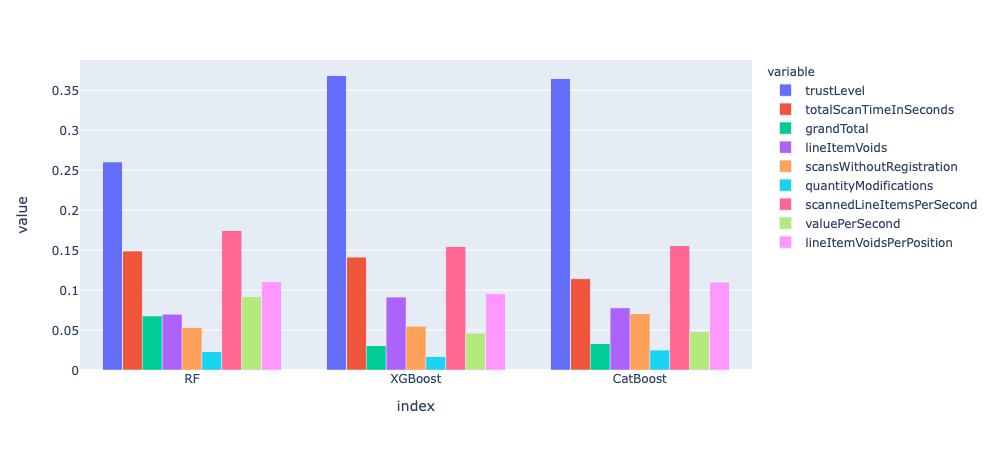

In [74]:
importances = pd.DataFrame([rf_importances, xgboost_importances, catboost_importances], index=['RF', 'XGBoost', 'CatBoost'], columns=train_feature.columns)
importances = importances.div(importances.sum(axis=1), axis=0)
px.bar(data_frame=importances, barmode='group')